In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/gold_price.csv'
df = pd.read_csv(file_path)

# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Clean numeric columns (remove commas, convert to float)
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

# Clean 'Change %'
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Convert Volume: e.g. '107.50K' -> 107500
def convert_volume(val):
    if isinstance(val, str):
        val = val.replace('K', 'e3').replace('M', 'e6')
        return float(eval(val))
    return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Vol.'] = df['Vol.'].fillna(method='ffill')  # Fill missing with forward fill


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-15-3445677992.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Vol.'] = df['Vol.'].fillna(method='ffill')  # Fill missing with forward fill


In [ ]:
# Lag and rolling features
df['Prev_Price'] = df['Price'].shift(1)
df['Price_Change'] = df['Price'] - df['Prev_Price']
df['7_day_avg'] = df['Price'].rolling(window=7).mean()
df['30_day_avg'] = df['Price'].rolling(window=30).mean()

# Drop rows with NaN values caused by shifting/rolling
df.dropna(inplace=True)

In [ ]:
selected_features = ['Open', 'Prev_Price', 'Price_Change', '7_day_avg']
X = df[selected_features]
y = df['Price']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

📊 Evaluation Metrics:
MAE:  7.97
RMSE: 10.97
R²:   0.9773


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


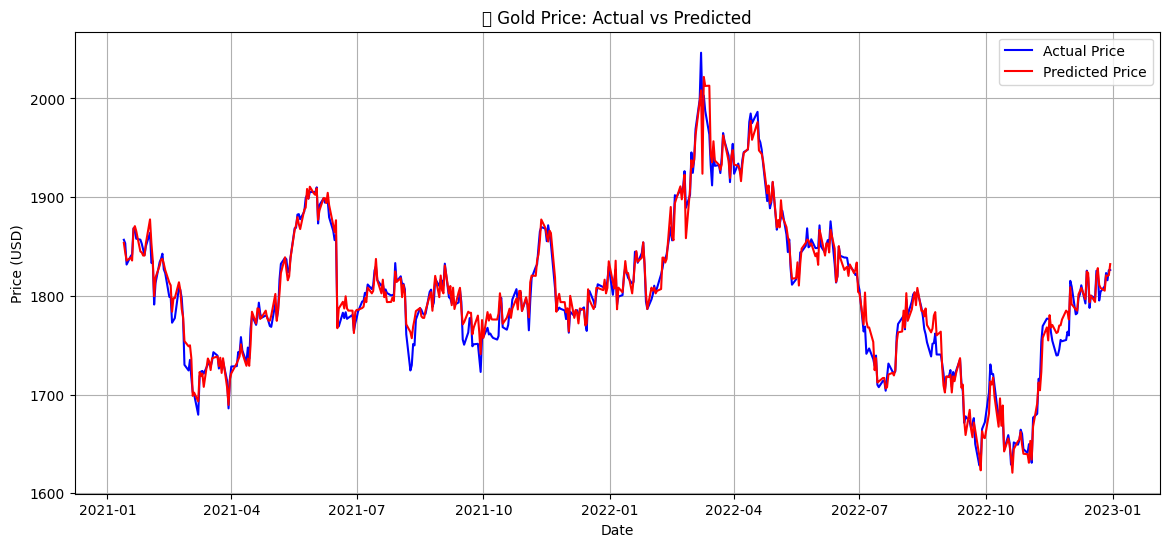

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test.values, label='Actual Price', color='blue')
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted Price', color='red')
plt.title("📉 Gold Price: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


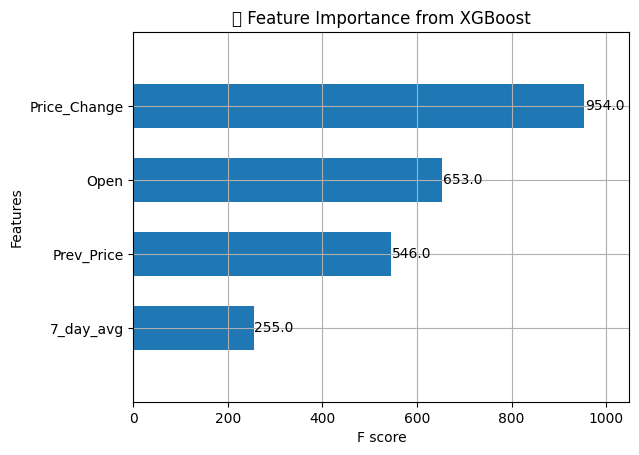

In [ ]:
xgb.plot_importance(model, height=0.6)
plt.title('🔍 Feature Importance from XGBoost')
plt.show()

In [ ]:
df.to_csv("gold_price.csv", index=False)


In [ ]:
import pickle
with open("gold_model.pkl", "wb") as f:
    pickle.dump(model, f)

from google.colab import files
files.download("gold_price.csv")
files.download("gold_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>